In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/cs461/data'

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [0]:
class Args:
  def __init__(self):
    self.use_cuda = True
    self.log_interval = 20
    self.train_batch_size = 64
    self.test_batch_size = 64
    self.lr = 0.01
    self.momentum = 0.9
    self.num_epochs = 3

args = Args()

In [11]:
device = torch.device('cpu')
if args.use_cuda and torch.cuda.is_available():
  device = torch.device('cuda:0')

print('Using {}.'.format(device))

Using cuda:0.


Load dataset and create data loaders.

In [0]:
def prepare_data(args):
  kwargs = {}
  if args.use_cuda and torch.cuda.is_available():
    kwargs = {'num_workers': 1, 'pin_memory': True}

  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)),
  ])

  # Load original training data.
  trainval_set = torchvision.datasets.FashionMNIST(
      root=data_dir, train=True, download=True, transform=transform)

  # Split original training data into training set and validation set
  # and create data loaders.
  train_set = torch.utils.data.Subset(trainval_set, range(50000))
  train_loader = torch.utils.data.DataLoader(
      train_set, batch_size=args.train_batch_size, shuffle=True, **kwargs)

  val_set = torch.utils.data.Subset(trainval_set, range(50000, 60000))
  val_loader = torch.utils.data.DataLoader(
      val_set, batch_size=args.test_batch_size, shuffle=False, **kwargs)

  # Load testing data and create data loader.
  test_set = torchvision.datasets.FashionMNIST(
      root=data_dir, train=False, download=True, transform=transform)
  test_loader = torch.utils.data.DataLoader(
      test_set, batch_size=args.test_batch_size, shuffle=False, **kwargs)
  
  return train_set, val_set, test_set, train_loader, val_loader, test_loader

Visualize some training samples.

0it [00:00, ?it/s]

26427392it [00:04, 5806910.29it/s]                              


Extracting /content/drive/My Drive/cs461/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/My Drive/cs461/data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 41275.66it/s]                           
0it [00:00, ?it/s]

Extracting /content/drive/My Drive/cs461/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/My Drive/cs461/data/FashionMNIST/raw


4423680it [00:02, 1661211.92it/s]                            
0it [00:00, ?it/s]

Extracting /content/drive/My Drive/cs461/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/My Drive/cs461/data/FashionMNIST/raw


8192it [00:00, 13927.94it/s]            


Extracting /content/drive/My Drive/cs461/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/My Drive/cs461/data/FashionMNIST/raw
Processing...
Done!


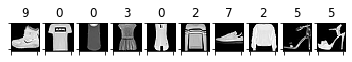

In [13]:
train_set, val_set, test_set, train_loader, val_loader, test_loader = prepare_data(args)

fig, axes = plt.subplots(1, 10)
for idx, ax in enumerate(axes):
  img, lbl = train_set[idx]
  ax.imshow(img[0], cmap='gray')
  ax.set_title(lbl)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
plt.show()

Define the model.

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc3 = nn.Linear(256, 10)

    self._initialize_weights()
  
  def _initialize_weights(self):
    pass

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, stride=2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, stride=2)
    x = torch.flatten(x, start_dim=1)
    x = self.fc3(x)
    return x

Define the training function.

In [0]:
def train(args, model, criterion, train_loader, optimizer, device):
  model.train()
  total_loss = 0.
  for i, data in enumerate(train_loader):
    imgs, lbls = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()
    outputs = model(imgs)
    loss = criterion(outputs, lbls)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    if (i + 1) % args.log_interval == 0:
      mean_loss = total_loss / args.log_interval
      print('  batch {:4d}: loss={:.3f}'.format(i + 1, mean_loss))
      total_loss = 0.

Define the testing function.

In [0]:
def test(args, model, test_loader, device):
  model.eval()
  total, correct = 0, 0
  with torch.no_grad():
    for data in test_loader:
      imgs, lbls = data[0].to(device), data[1].to(device)
      outputs = model(imgs)
      _, preds = torch.max(outputs.data, 1)
      total += lbls.shape[0]
      correct += (preds == lbls).sum().item()

  acc = correct / total
  print('  acc={:.3f}'.format(acc))

Run training and validation.

In [0]:
model = Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=args.lr,
    momentum=args.momentum
)

for e in range(args.num_epochs):
  print('Training epoch {}'.format(e))
  train(args, model, criterion, train_loader, optimizer, device)
  print('Testing on validation set')
  test(args, model, val_loader, device)

Training epoch 0
  batch   20: loss=2.220
  batch   40: loss=1.519
  batch   60: loss=0.880
  batch   80: loss=0.774
  batch  100: loss=0.773
  batch  120: loss=0.721
  batch  140: loss=0.658
  batch  160: loss=0.667
  batch  180: loss=0.613
  batch  200: loss=0.633
  batch  220: loss=0.609
  batch  240: loss=0.612
  batch  260: loss=0.609
  batch  280: loss=0.585
  batch  300: loss=0.533
  batch  320: loss=0.515
  batch  340: loss=0.611
  batch  360: loss=0.556
  batch  380: loss=0.553
  batch  400: loss=0.486
  batch  420: loss=0.490
  batch  440: loss=0.482
  batch  460: loss=0.514
  batch  480: loss=0.469
  batch  500: loss=0.474
  batch  520: loss=0.483
  batch  540: loss=0.451
  batch  560: loss=0.490
  batch  580: loss=0.500
  batch  600: loss=0.433
  batch  620: loss=0.515
  batch  640: loss=0.449
  batch  660: loss=0.473
  batch  680: loss=0.418
  batch  700: loss=0.464
  batch  720: loss=0.440
  batch  740: loss=0.415
  batch  760: loss=0.436
  batch  780: loss=0.409
Testing 

Question 1: Evaluating trained model on test set

In [0]:
test(args, model, test_loader, device)

  acc=0.870


Question 2: Modifying model & training scheme for improvement

Part 1: Smaller batch size

In [0]:
model1 = Net()
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model1.parameters(),
    lr=args.lr,
    momentum=args.momentum
)

args.train_batch_size = 32

for e in range(args.num_epochs):
  print('Training epoch {}'.format(e))
  train(args, model1, criterion, train_loader, optimizer, device)
  print('Testing on validation set')
  test(args, model1, val_loader, device)

Training epoch 0
  batch   20: loss=2.214
  batch   40: loss=1.488
  batch   60: loss=1.027
  batch   80: loss=0.858
  batch  100: loss=0.797
  batch  120: loss=0.744
  batch  140: loss=0.680
  batch  160: loss=0.659
  batch  180: loss=0.640
  batch  200: loss=0.660
  batch  220: loss=0.611
  batch  240: loss=0.599
  batch  260: loss=0.603
  batch  280: loss=0.582
  batch  300: loss=0.547
  batch  320: loss=0.566
  batch  340: loss=0.545
  batch  360: loss=0.566
  batch  380: loss=0.530
  batch  400: loss=0.518
  batch  420: loss=0.526
  batch  440: loss=0.506
  batch  460: loss=0.464
  batch  480: loss=0.469
  batch  500: loss=0.466
  batch  520: loss=0.435
  batch  540: loss=0.472
  batch  560: loss=0.494
  batch  580: loss=0.443
  batch  600: loss=0.510
  batch  620: loss=0.434
  batch  640: loss=0.441
  batch  660: loss=0.450
  batch  680: loss=0.432
  batch  700: loss=0.474
  batch  720: loss=0.451
  batch  740: loss=0.411
  batch  760: loss=0.421
  batch  780: loss=0.407
Testing 

A smaller batch size of 32 decreased accuracy very slightly.

Part 2: More epochs (original batch size)

In [0]:
model2 = Net()
model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model2.parameters(),
    lr=args.lr,
    momentum=args.momentum
)

args.num_epochs = 10
args.train_batch_size = 64

for e in range(args.num_epochs):
  print('Training epoch {}'.format(e))
  train(args, model2, criterion, train_loader, optimizer, device)
  print('Testing on validation set')
  test(args, model2, val_loader, device)

Training epoch 0
  batch   20: loss=2.184
  batch   40: loss=1.409
  batch   60: loss=0.972
  batch   80: loss=0.875
  batch  100: loss=0.827
  batch  120: loss=0.731
  batch  140: loss=0.642
  batch  160: loss=0.642
  batch  180: loss=0.583
  batch  200: loss=0.618
  batch  220: loss=0.651
  batch  240: loss=0.583
  batch  260: loss=0.569
  batch  280: loss=0.580
  batch  300: loss=0.532
  batch  320: loss=0.526
  batch  340: loss=0.554
  batch  360: loss=0.480
  batch  380: loss=0.477
  batch  400: loss=0.489
  batch  420: loss=0.497
  batch  440: loss=0.534
  batch  460: loss=0.513
  batch  480: loss=0.504
  batch  500: loss=0.437
  batch  520: loss=0.472
  batch  540: loss=0.463
  batch  560: loss=0.448
  batch  580: loss=0.464
  batch  600: loss=0.491
  batch  620: loss=0.437
  batch  640: loss=0.414
  batch  660: loss=0.467
  batch  680: loss=0.477
  batch  700: loss=0.449
  batch  720: loss=0.427
  batch  740: loss=0.406
  batch  760: loss=0.410
  batch  780: loss=0.426
Testing 

Increasing the number of epochs increased accuracy by over 1%.

Part 3: Lower learning rate (increased number of epochs)

In [0]:
args.lr = 0.001

model3 = Net()
model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model3.parameters(),
    lr=args.lr,
    momentum=args.momentum
)

for e in range(args.num_epochs):
  print('Training epoch {}'.format(e))
  train(args, model3, criterion, train_loader, optimizer, device)
  print('Testing on validation set')
  test(args, model3, val_loader, device)

Training epoch 0
  batch   20: loss=2.296
  batch   40: loss=2.268
  batch   60: loss=2.220
  batch   80: loss=2.173
  batch  100: loss=2.078
  batch  120: loss=1.946
  batch  140: loss=1.767
  batch  160: loss=1.592
  batch  180: loss=1.390
  batch  200: loss=1.207
  batch  220: loss=1.086
  batch  240: loss=1.018
  batch  260: loss=0.966
  batch  280: loss=0.947
  batch  300: loss=0.884
  batch  320: loss=0.873
  batch  340: loss=0.865
  batch  360: loss=0.787
  batch  380: loss=0.813
  batch  400: loss=0.798
  batch  420: loss=0.828
  batch  440: loss=0.728
  batch  460: loss=0.762
  batch  480: loss=0.757
  batch  500: loss=0.772
  batch  520: loss=0.761
  batch  540: loss=0.743
  batch  560: loss=0.668
  batch  580: loss=0.709
  batch  600: loss=0.706
  batch  620: loss=0.715
  batch  640: loss=0.670
  batch  660: loss=0.713
  batch  680: loss=0.719
  batch  700: loss=0.668
  batch  720: loss=0.696
  batch  740: loss=0.646
  batch  760: loss=0.681
  batch  780: loss=0.660
Testing 

The lower learning rate slightly decreases the validation accuracy.

Part 4: Adding more channels from layer 1 to 2

In [0]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 16, 5)
    self.fc3 = nn.Linear(256, 10)

    self._initialize_weights()
  
  def _initialize_weights(self):
    pass

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, stride=2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, stride=2)
    x = torch.flatten(x, start_dim=1)
    x = self.fc3(x)
    return x

args.lr = 0.01

model4 = Net2()
model4.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model4.parameters(),
    lr=args.lr,
    momentum=args.momentum
)

for e in range(args.num_epochs):
  print('Training epoch {}'.format(e))
  train(args, model4, criterion, train_loader, optimizer, device)
  print('Testing on validation set')
  test(args, model4, val_loader, device)

Training epoch 0
  batch   20: loss=2.113
  batch   40: loss=1.215
  batch   60: loss=0.864
  batch   80: loss=0.770
  batch  100: loss=0.762
  batch  120: loss=0.706
  batch  140: loss=0.684
  batch  160: loss=0.641
  batch  180: loss=0.572
  batch  200: loss=0.573
  batch  220: loss=0.580
  batch  240: loss=0.548
  batch  260: loss=0.473
  batch  280: loss=0.506
  batch  300: loss=0.533
  batch  320: loss=0.503
  batch  340: loss=0.508
  batch  360: loss=0.550
  batch  380: loss=0.474
  batch  400: loss=0.440
  batch  420: loss=0.460
  batch  440: loss=0.458
  batch  460: loss=0.423
  batch  480: loss=0.478
  batch  500: loss=0.481
  batch  520: loss=0.438
  batch  540: loss=0.444
  batch  560: loss=0.397
  batch  580: loss=0.409
  batch  600: loss=0.449
  batch  620: loss=0.436
  batch  640: loss=0.425
  batch  660: loss=0.388
  batch  680: loss=0.447
  batch  700: loss=0.371
  batch  720: loss=0.458
  batch  740: loss=0.416
  batch  760: loss=0.391
  batch  780: loss=0.399
Testing 

Increasing the number of channels for the convolutional layers increases the accuracy on the validation set by a good amount.

Part 5: Dropout layer after the first convolutional layer for regularization

In [0]:
class Net3(nn.Module):
  def __init__(self):
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.dropout1 = nn.Dropout(p=0.3)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc3 = nn.Linear(256, 10)

    self._initialize_weights()
  
  def _initialize_weights(self):
    pass

  def forward(self, x):
    x = F.relu(self.conv1(x))
    if self.training:
      x = self.dropout1(x)
    x = F.max_pool2d(x, 2, stride=2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, stride=2)
    x = torch.flatten(x, start_dim=1)
    x = self.fc3(x)
    return x



model5 = Net3()
model5.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model5.parameters(),
    lr=args.lr,
    momentum=args.momentum
)

for e in range(args.num_epochs):
  print('Training epoch {}'.format(e))
  train(args, model5, criterion, train_loader, optimizer, device)
  print('Testing on validation set')
  test(args, model5, val_loader, device)

Training epoch 0
  batch   20: loss=2.127
  batch   40: loss=1.233
  batch   60: loss=0.976
  batch   80: loss=0.865
  batch  100: loss=0.712
  batch  120: loss=0.643
  batch  140: loss=0.619
  batch  160: loss=0.682
  batch  180: loss=0.621
  batch  200: loss=0.607
  batch  220: loss=0.584
  batch  240: loss=0.616
  batch  260: loss=0.586
  batch  280: loss=0.589
  batch  300: loss=0.515
  batch  320: loss=0.546
  batch  340: loss=0.527
  batch  360: loss=0.550
  batch  380: loss=0.517
  batch  400: loss=0.493
  batch  420: loss=0.517
  batch  440: loss=0.508
  batch  460: loss=0.466
  batch  480: loss=0.468
  batch  500: loss=0.492
  batch  520: loss=0.465
  batch  540: loss=0.440
  batch  560: loss=0.463
  batch  580: loss=0.446
  batch  600: loss=0.448
  batch  620: loss=0.466
  batch  640: loss=0.415
  batch  660: loss=0.473
  batch  680: loss=0.426
  batch  700: loss=0.454
  batch  720: loss=0.458
  batch  740: loss=0.474
  batch  760: loss=0.433
  batch  780: loss=0.430
Testing 

The dropout layer increase the accuracy slightly

Question 3 - Best network: Increased number of epochs, dropout layer, and increased number of channels

In [15]:
class BestNet(nn.Module):
  def __init__(self):
    super(BestNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.dropout1 = nn.Dropout(p=0.3)
    self.conv2 = nn.Conv2d(32, 16, 5)
    self.fc3 = nn.Linear(256, 10)

    self._initialize_weights()
  
  def _initialize_weights(self):
    pass

  def forward(self, x):
    x = F.relu(self.conv1(x))
    if self.training:
      x = self.dropout1(x)
    x = F.max_pool2d(x, 2, stride=2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, stride=2)
    x = torch.flatten(x, start_dim=1)
    x = self.fc3(x)
    return x

best_model = BestNet()
best_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    best_model.parameters(),
    lr=args.lr,
    momentum=args.momentum
)

for e in range(args.num_epochs):
  print('Training epoch {}'.format(e))
  train(args, best_model, criterion, train_loader, optimizer, device)
  print('Testing on validation set')
  test(args, best_model, val_loader, device)

Training epoch 0
  batch   20: loss=2.058
  batch   40: loss=1.118
  batch   60: loss=0.813
  batch   80: loss=0.748
  batch  100: loss=0.703
  batch  120: loss=0.655
  batch  140: loss=0.623
  batch  160: loss=0.581
  batch  180: loss=0.558
  batch  200: loss=0.541
  batch  220: loss=0.493
  batch  240: loss=0.525
  batch  260: loss=0.532
  batch  280: loss=0.504
  batch  300: loss=0.476
  batch  320: loss=0.525
  batch  340: loss=0.485
  batch  360: loss=0.504
  batch  380: loss=0.469
  batch  400: loss=0.420
  batch  420: loss=0.447
  batch  440: loss=0.413
  batch  460: loss=0.432
  batch  480: loss=0.444
  batch  500: loss=0.452
  batch  520: loss=0.428
  batch  540: loss=0.431
  batch  560: loss=0.413
  batch  580: loss=0.387
  batch  600: loss=0.407
  batch  620: loss=0.411
  batch  640: loss=0.393
  batch  660: loss=0.385
  batch  680: loss=0.378
  batch  700: loss=0.388
  batch  720: loss=0.424
  batch  740: loss=0.414
  batch  760: loss=0.388
  batch  780: loss=0.422
Testing 

Evaluating the best network on the test set

In [16]:
  test(args, best_model, val_loader, device)

  acc=0.880


The best network was able to reach 88% accuracy, which probably can be outperformed with further optimization of hyperparameters and architecture